# Imports

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np

import sys
sys.path.append('../')
from src.utils.data_preprocessing import load_processed_data
from src.models.vgg16_1D import VGG16_1D
from src.utils.tensor_preprocessing import TensorPreprocessor
from src.utils.model_training import ModelTrainer
from src.utils.model_tresholds import ThresholdOptimizer
from src.utils.model_evaluation import ModelEvaluation

# Variables

In [2]:
DATA_DIR = "../data/raw/ptb_xl_ecg/"
SAMPLING_FREQUENCY = 100
TASK = "superdiagnostic"
CLASS_NAMES = ['MI', 'NORM', 'OTHER']
SCALER_DIR = f"../data/results/scaler/"
PREPROCESSED_DIR = f"../data/preprocessed/"

# Load Data

In [3]:
# 1. Daten laden
X_train, y_train = load_processed_data(PREPROCESSED_DIR, "train")
X_val, y_val = load_processed_data(PREPROCESSED_DIR, "val")
X_test, y_test = load_processed_data(PREPROCESSED_DIR, "test")

In [4]:
print(y_train.shape)  # Sollte (n_samples, 3) sein, nicht (n_samples,)
print(y_train[:5])    # Sollte z.B. [[1,0,0],[0,1,0],...] sein

(17084,)
[1 1 1 1 1]


In [5]:
# Nach dem Laden:
if y_train.ndim == 1:
    y_train = np.eye(len(CLASS_NAMES))[y_train]
if y_val.ndim == 1:
    y_val = np.eye(len(CLASS_NAMES))[y_val]
if y_test.ndim == 1:
    y_test = np.eye(len(CLASS_NAMES))[y_test]

In [6]:
print(y_train.shape)  # Sollte (n_samples, 3) sein, nicht (n_samples,)
print(y_train[:5])    # Sollte z.B. [[1,0,0],[0,1,0],...] sein

(17084, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [7]:
splits = {'Train': y_train, 'Validation': y_val, 'Test': y_test}

for split_name, y_split in splits.items():
    y_arr = np.asarray(y_split)
    # Multi-Label: Summiere pro Klasse (Spalte)
    if y_arr.ndim == 2 and y_arr.shape[1] == len(CLASS_NAMES):
        counts = y_arr.sum(axis=0)
    else:
        counts = np.bincount(y_arr, minlength=len(CLASS_NAMES))
    perc = counts / counts.sum() * 100
    print(f"{split_name}:")
    for name, c, p in zip(CLASS_NAMES, counts, perc):
        print(f"  {name}: {int(c)} ({p:.2f}%)")
    print(f"  TOTAL: {int(counts.sum())} (100.00%)\n")

Train:
  MI: 4379 (25.63%)
  NORM: 7595 (44.46%)
  OTHER: 5110 (29.91%)
  TOTAL: 17084 (100.00%)

Validation:
  MI: 540 (25.16%)
  NORM: 955 (44.50%)
  OTHER: 651 (30.34%)
  TOTAL: 2146 (100.00%)

Test:
  MI: 550 (25.49%)
  NORM: 963 (44.62%)
  OTHER: 645 (29.89%)
  TOTAL: 2158 (100.00%)



# Load Model

In [8]:
model = VGG16_1D(in_channels=12, num_classes=len(CLASS_NAMES), input_length=1000)

# Load Tensors

In [9]:
tp = TensorPreprocessor()

In [10]:
# Trainingsdaten (und Labels) in TensorDataset umwandeln, inkl. Permute falls nötig
train_dataset = tp.to_dataset(X_train, y_train.astype(np.float32), expected_channels=12, expected_length=1000)
val_dataset = tp.to_dataset(X_val, y_val.astype(np.float32), expected_channels=12, expected_length=1000)
test_dataset = tp.to_dataset(X_test, y_test.astype(np.float32), expected_channels=12, expected_length=1000)

[Auto-Fix] Initiale Prüfung:
--- Tensor Shape Check ---
X_tensor: shape=(17084, 1000, 12), dtype=torch.float32
y_tensor: shape=(17084, 3), dtype=torch.int64
Warnung: Channels (X_tensor.shape[1]=1000) stimmt nicht mit expected_channels=12 überein!
Warnung: Length (X_tensor.shape[2]=12) stimmt nicht mit expected_length=1000 überein!
--------------------------
[Auto-Fix] Versuche Shape automatisch zu korrigieren...
Shape-Fix: Permutiere von (Batch, Length, Channels) zu (Batch, Channels, Length)
--- Tensor Shape Check ---
X_tensor: shape=(17084, 12, 1000), dtype=torch.float32
y_tensor: shape=(17084, 3), dtype=torch.int64
Alles korrekt: Tensor-Formate stimmen überein.
--------------------------
[Auto-Fix] Initiale Prüfung:
--- Tensor Shape Check ---
X_tensor: shape=(2146, 1000, 12), dtype=torch.float32
y_tensor: shape=(2146, 3), dtype=torch.int64
Warnung: Channels (X_tensor.shape[1]=1000) stimmt nicht mit expected_channels=12 überein!
Warnung: Length (X_tensor.shape[2]=12) stimmt nicht mit 

In [11]:
train_dataset.tensors = (train_dataset.tensors[0], train_dataset.tensors[1].float())
val_dataset.tensors = (val_dataset.tensors[0], val_dataset.tensors[1].float())
test_dataset.tensors = (test_dataset.tensors[0], test_dataset.tensors[1].float())

In [12]:
# DataLoader erzeugen
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model Training

In [13]:
# y_train enthält alle Trainingslabels als Multi-Hot (Multi-Label)
if isinstance(y_train, np.ndarray) and y_train.ndim == 2:
    class_counts = y_train.sum(axis=0)
else:
    class_counts = np.bincount(y_train)

In [14]:
class_weights = 1.0 / class_counts   # Inverse Häufigkeit
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normierung
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Initialize the loss function, used for
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
# Initialize the ModelTrainer, for managing the training process
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, criterion)

In [ ]:
# Start training the model mit Evaluation nach jeder Epoche (Multi-Label)
#thresholds = [0.3, 0.7, 0.3]  # MI, NORM, OTHER
#trainer.train(num_epochs=10, eval_fn=ModelEvaluation.compute_metrics, threshold=thresholds)

In [ ]:
# save trained model
#path = "../src/models/trained/vgg16_1d_trained.pth"
#trainer.save_model(path)

In [18]:
# load existing model
path = "../src/models/trained/vgg16_1d_trained.pth"
trainer.load_model(path)

c:\Users\AliceKitchkin\Repos\ECG_xAI\notebooks\..\src\utils\model_training.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path, 

## Thresholds

In [19]:
# Nach dem Modelltraining: Validierungslauf
y_true_val, y_probs_val = trainer.inferencing(val_loader)

In [20]:
# CLASS_NAMES = ['MI', 'NORM', 'OTHER']
metrics_config = {0: 'recall_weighted', 1: 'precision_weighted', 2: 'recall_weighted'}
threshold_optimizer = ThresholdOptimizer(metrics_config, beta=1.5)

In [21]:
optimal_thresholds = threshold_optimizer.optimize(y_true_val, y_probs_val)
print(f"Finale optimierte Schwellenwerte: {optimal_thresholds}")

Optimizing Thresholds: 100%|██████████| 3/3 [00:00<00:00, 43.43it/s]

Optimaler Schwellenwert für Label 0 (recall_weighted): 0.30 mit Score 0.5053
Optimaler Schwellenwert für Label 1 (precision_weighted): 0.50 mit Score 0.6021
Optimaler Schwellenwert für Label 2 (recall_weighted): 0.20 mit Score 0.4532
Finale optimierte Schwellenwerte: {0: 0.30000000000000004, 1: 0.5000000000000001, 2: 0.20000000000000004}


# Evaluation on Validation Data

In [22]:
y_pred_val = (y_probs_val >= list(optimal_thresholds.values())).astype(int)

In [23]:
# Metriken berechnen und ausgeben
val_metrics = ModelEvaluation.compute_metrics(y_true_val, y_pred_val)
ModelEvaluation.print_metrics(val_metrics, class_names=CLASS_NAMES)


--- Evaluation Metrics ---
accuracy: 0.5829
f1_weighted: 0.7435
precision_weighted: 0.6935
recall_weighted: 0.8350
f1_per_class:
  MI: 0.7217
  NORM: 0.8168
  OTHER: 0.6539
precision_per_class:
  MI: 0.6231
  NORM: 0.8547
  OTHER: 0.5155
recall_per_class:
  MI: 0.8574
  NORM: 0.7822
  OTHER: 0.8940


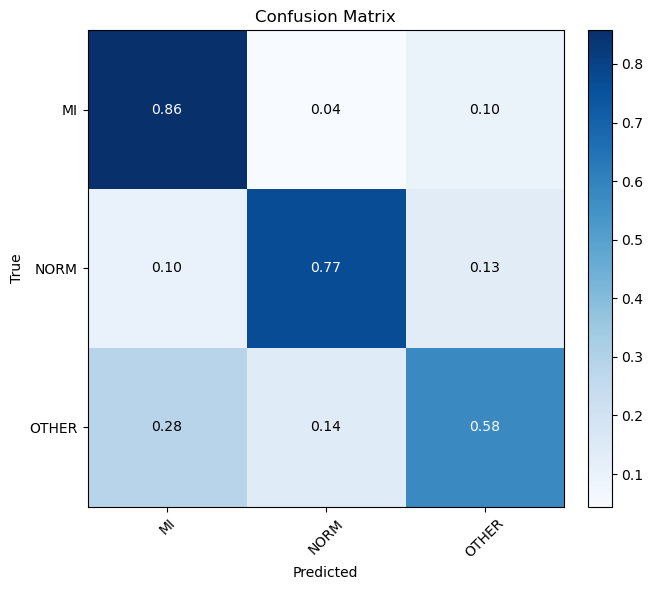

In [24]:
ModelEvaluation.plot_confusion_matrix(y_true_val, y_pred_val, class_names=CLASS_NAMES, normalize=True)

In [ ]:
# Loss-Kurven plotten (hierfür werden die in der Trainer-Klasse gespeicherten Verluste benötigt)
# Trainer.train_losses, Trainer.val_losses, Trainer.train_losses_per_class, Trainer.val_losses_per_class
# Annahme: Sie haben diese Werte vom Trainer-Objekt gespeichert oder als Attribut zugänglich gemacht.
# Beispiel:
# trainer = ModelTrainer(...)
# trainer.train(...)
# ModelEvaluation.plot_loss_curves(
#     train_losses=trainer.train_losses, 
#     val_losses=trainer.val_losses,
#     train_losses_per_class=trainer.train_losses_per_class,
#     val_losses_per_class=trainer.val_losses_per_class,
#     class_names=CLASS_NAMES
# )

# Evaluation on Test Data

In [26]:
y_true_test, y_probs_test = trainer.inferencing(test_loader)

In [27]:
y_pred_test = (y_probs_test >= list(optimal_thresholds.values())).astype(int)

In [28]:
test_metrics = ModelEvaluation.compute_metrics(y_true_test, y_pred_test)
ModelEvaluation.print_metrics(test_metrics, class_names=CLASS_NAMES)


--- Evaluation Metrics ---
accuracy: 0.5788
f1_weighted: 0.7428
precision_weighted: 0.6899
recall_weighted: 0.8360
f1_per_class:
  MI: 0.7135
  NORM: 0.8283
  OTHER: 0.6402
precision_per_class:
  MI: 0.6153
  NORM: 0.8568
  OTHER: 0.5045
recall_per_class:
  MI: 0.8491
  NORM: 0.8017
  OTHER: 0.8760


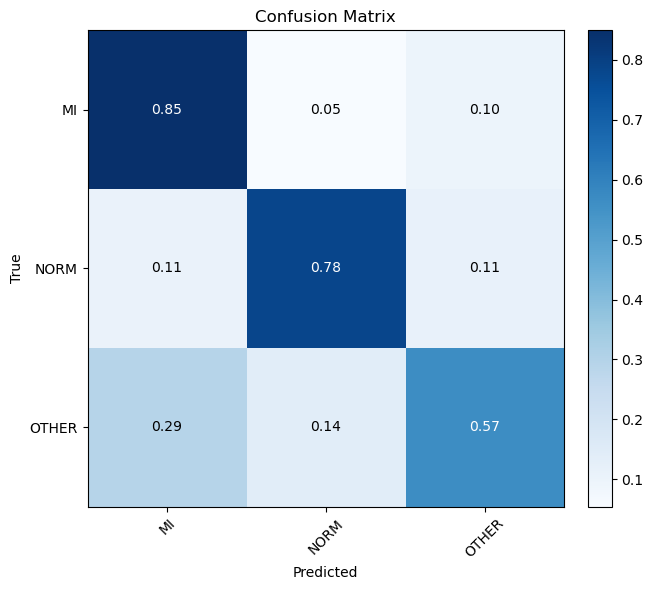

In [29]:
ModelEvaluation.plot_confusion_matrix(y_true_test, y_pred_test, class_names=CLASS_NAMES, normalize=True)